# Prepare data for training

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

## Read data

The data is saved in numpy arrays. 
Each array has shape $\texttt{n\_images} \times \texttt{height} \times \texttt{width} \times \texttt{n\_channels}$.
Number of channels is 1 for CT scans (grayscale images) and 4 for masks, because there are 4 masks:
* "ground glass"
* "consolidation"
* "lungs other"
* "background"

In [2]:
prefix = Path("covid-segmentation-data/")

images_radiopedia = np.load(prefix / "images_radiopedia.npy").astype(np.float32)
masks_radiopedia = np.load(prefix / "masks_radiopedia.npy").astype(np.int8)
images_medseg = np.load(prefix / "images_medseg.npy").astype(np.float32)
masks_medseg = np.load(prefix / "masks_medseg.npy").astype(np.int8)

test_images_medseg = np.load(prefix / "test_images_medseg.npy").astype(np.float32)

## Remove samples with no target masks

Remove samples which don't contain any of ground glass nor consolidation

In [3]:
ground_glass_or_consolidations_mask = np.any(
    masks_radiopedia[..., 0] | masks_radiopedia[..., 1], axis=(1, 2)
)
print(ground_glass_or_consolidations_mask.sum())

372


In [4]:
images_radiopedia = images_radiopedia[ground_glass_or_consolidations_mask]
masks_radiopedia = masks_radiopedia[ground_glass_or_consolidations_mask]

## Train validation split

In [5]:
val_indexes, train_indexes = list(range(24)), list(range(24, 100))

train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg[train_indexes], masks_radiopedia))
val_images = images_medseg[val_indexes]
val_masks = masks_medseg[val_indexes]

del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

## Normalize grayscale images

The normalization is taken from [keras baseline.ipynb](https://www.kaggle.com/code/maedemaftouni/pytorch-baseline-for-semantic-segmentation), however I rewrote it as scikit learn transformer myself:

In [6]:
def clip_values(images_arr):
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500


def normalize(X):
    X = X.copy()
    clip_values(X)
    return (X - X.min()) / (X.max() - X.min())

In [7]:
train_images_processed = normalize(train_images)
val_images_processed = normalize(val_images)
test_images_processed = normalize(test_images_medseg)

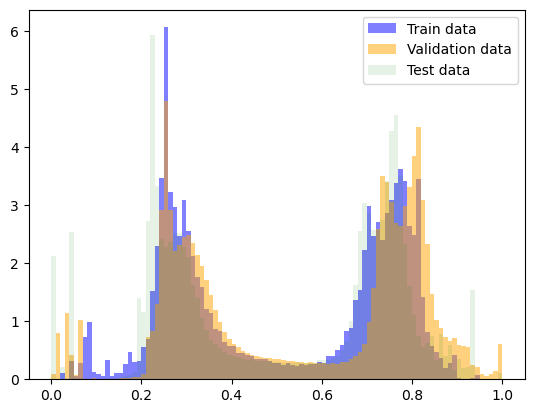

In [8]:
fig, ax = plt.subplots()

ax.hist(
    train_images_processed.ravel(),
    bins=100,
    density=True,
    color="b",
    alpha=0.5,
    label="Train data",
)
ax.hist(
    val_images_processed.ravel(),
    bins=100,
    density=True,
    alpha=0.5,
    color="orange",
    label="Validation data",
)
ax.hist(
    test_images_processed.ravel(),
    bins=100,
    density=True,
    alpha=0.1,
    color="green",
    label="Test data",
)
ax.legend()
plt.show()

## Drop lungs and background channels

In [10]:
train_masks = train_masks[..., :2]
val_masks = val_masks[..., :2]

## Upload data to S3

In [11]:
processed_dir = Path("processed")
train_dir = processed_dir / "train"
val_dir = processed_dir / "val"
test_dir = processed_dir / "test"

for path in (processed_dir, train_dir, val_dir, test_dir):
    path.mkdir(exist_ok=True)

In [13]:
np.save(train_dir / "images.npy", train_images_processed)
np.save(train_dir / "masks.npy", train_masks)

np.save(val_dir / "images.npy", val_images_processed)
np.save(val_dir / "masks.npy", val_masks)

np.save(test_dir / "images.npy", test_images_processed)

In [14]:
import boto3
import sagemaker

s3_client = boto3.client('s3')
sess = sagemaker.Session()
bucket = sess.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [15]:
files_to_upload = (
    train_dir / "images.npy",
    train_dir / "masks.npy",
    val_dir / "images.npy",
    val_dir / "masks.npy",
    test_dir / "images.npy",
)

for file_path in files_to_upload:
    s3_client.upload_file(file_path, bucket, "data/" + str(file_path))

*The notebook was run on `ml.t3.large`*